# Mixture Density Network (both dependent and independent)
- Dependent: each output dimension has dependent mixtures
- Independent: each output dimension has independent mixtures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from util import suppress_tf_warning,get_vars,gpu_sess,NormalizerClass,get_mdn_training_data
suppress_tf_warning()
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("TF version:[%s]."%(tf.__version__))

TF version:[1.15.0].


### MDN Class

### Three heuristics:
- sig_max
- mu_min and mu_max
- epi_reg_coef

In [2]:
tfd = tf.contrib.distributions
tfrni = tf.random_normal_initializer
tfci = tf.constant_initializer
tfrui = tf.random_uniform_initializer

class MixtureDensityNetworkClass(object):
    """
    Mixture density network 
    """
    def __init__(self,name='MDN',x_dim=1,y_dim=2,k=5,h_dims=[32,32],actv=tf.nn.tanh,sig_max=0,
                 mu_min=-3,mu_max=3,l2_reg_coef=1e-8,epi_reg_coef=1e-6,
                 DEPENDENT_OUTPUT=True):
        """
        Initialize
        """
        self.name = name
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.k = k # number of mixtures
        self.h_dims = h_dims
        self.actv = actv
        self.sig_max = sig_max
        
        self.mu_min = mu_min
        self.mu_max = mu_max
        self.l2_reg_coef = l2_reg_coef
        self.epi_reg_coef = epi_reg_coef
        
        self.DEPENDENT_OUTPUT = DEPENDENT_OUTPUT
        
        self.build_model()
        self.build_graph()
        
    def build_model(self):
        """
        Build model
        """
        self.ph_x = tf.placeholder(dtype=tf.float32,shape=[None,self.x_dim],name='x')
        self.ph_y = tf.placeholder(dtype=tf.float32,shape=[None,self.y_dim],name='y')
        
        with tf.variable_scope(self.name,reuse=False):
            net = self.ph_x
            for h_idx,h_dim in enumerate(self.h_dims):
                net = tf.layers.dense(
                    net,h_dim,activation=self.actv,kernel_initializer=tfrni(stddev=0.01),
                    bias_initializer=tfci(value=0),name='hid_%d'%(h_idx))
            # Pi 
            if self.DEPENDENT_OUTPUT:
                # [N x k]
                self.pi_logit = tf.layers.dense(
                    net,self.k,activation=None,kernel_initializer=tfrni(stddev=0.01),
                    bias_initializer=tfci(value=0),name='pi')
                self.pi = tf.nn.softmax(self.pi_logit,axis=1) # [N x k]
            else:
                # [N x y_dim x k]
                self.pi = tf.layers.dense(net,self.y_dim*self.k,activation=None,
                                          kernel_initializer=tfrni(stddev=0.01),bias_initializer=tfci(0),
                                          name='pi') 
                self.pi = tf.reshape(self.pi,shape=(-1,self.y_dim,self.k)) # [n x y_dim x k]
                self.pi = tf.nn.softmax(self.pi,axis=2)
                
            # Mu [N x y_dim x k]
            # (bias_initializer is important!)
            self.mu_raw = tf.layers.dense(
                net,self.y_dim*self.k,activation=None,kernel_initializer=tfrni(stddev=0.01),
                bias_initializer=tfrui(minval=self.mu_min,maxval=self.mu_max),name='mu') # [N x y_dim*k]
            self.mu = tf.reshape(self.mu_raw,shape=(-1,self.y_dim,self.k)) # [N x y_dim x k]
            # Var [N x y_dim x k]
            self.log_var_raw = tf.layers.dense(
                net,self.y_dim*self.k,activation=None,kernel_initializer=tfrni(stddev=0.01),
                bias_initializer=tfci(0),name='logvar') # [N x y_dim*k]
            self.log_var = tf.reshape(self.log_var_raw,shape=(-1,self.y_dim,self.k)) # [N x y_dim x k]
            if self.sig_max == 0:
                self.var = tf.exp(self.log_var)
            else:
                self.var = self.sig_max*tf.sigmoid(self.log_var)
        self.tf_vars = get_vars(scope=self.name)
        
        
    def build_graph(self):
        """
        Build graph
        """
        # Basic GMM 
        if self.DEPENDENT_OUTPUT:
            self.cat = tfd.Categorical(probs=self.pi) # categorical r.v.
            self.comps = [tfd.MultivariateNormalDiag(loc=loc,scale_diag=tf.sqrt(scale))
                          for loc,scale in zip(tf.unstack(tf.transpose(self.mu,[2,0,1])),
                                               tf.unstack(tf.transpose(self.var,[2,0,1])))]
            self.tfd_mog = tfd.Mixture(cat=self.cat,components=self.comps) # mixture of Gaussian 
            self.log_liks = self.tfd_mog.log_prob(self.ph_y) # [n]
            self.log_lik = tf.reduce_mean(self.log_liks) # [1]
            # pi:[n x k] / mu:[n x d x k] / var:[n x d x k]

            # Aleatoric uncertainty
            pi_axis = self.pi[:,:,tf.newaxis]
            self.aleatoric_uncts = tf.squeeze(tf.matmul(self.var,pi_axis),axis=2) # [n x y_dim]
            self.aleatoric_unct = tf.reduce_sum(self.aleatoric_uncts,axis=1) # [n]

            # Epistemic uncertainty
            mu_average = tf.matmul(self.mu,self.pi[:,:,tf.newaxis]) # [n x y_dim x 1]
            mu_diff_sq = tf.square(self.mu-mu_average) # [n x y_dim x k]
            self.epistemic_uncts = tf.squeeze(tf.matmul(mu_diff_sq,pi_axis),axis=2) # [n x y_dim]
            self.epistemic_unct = tf.reduce_sum(self.epistemic_uncts,axis=1) # [n]
        else:
            self.cat = tfd.Categorical(probs=self.pi) # categorical r.v.
            self.comps = [tfd.Normal(loc=loc,scale=tf.sqrt(scale))
                          for loc,scale in zip(tf.unstack(tf.transpose(self.mu,[2,0,1])),
                                               tf.unstack(tf.transpose(self.var,[2,0,1])))]
            self.tfd_mog = tfd.Mixture(cat=self.cat,components=self.comps) # mixture of Gaussian [n x d]
            self.log_liks = self.tfd_mog.log_prob(self.ph_y) # [n x 2]
            self.log_lik = tf.reduce_mean(self.log_liks) # [1]
            
            # Aleatoric uncertainty
            self.aleatoric_uncts = tf.reduce_sum(tf.multiply(self.var,self.pi),axis=2) # [n x y_dim]
            self.aleatoric_unct = tf.reduce_sum(self.aleatoric_uncts,axis=1) # [n]
            
            # Epistemic uncertainty
            mu_average = tf.reduce_sum(tf.multiply(self.mu,self.pi),axis=2) # [n x y_dim x k] => [n x y_dim]
            mu_diff_sq = tf.square(self.mu-tf.tile(mu_average[:,:,tf.newaxis],[1,1,self.k])) # [n x y_dim x k]
            self.epistemic_uncts = tf.reduce_sum(tf.multiply(mu_diff_sq,self.pi),axis=2) # [n x y_dim]
            self.epistemic_unct = tf.reduce_sum(self.epistemic_uncts,axis=1) # [n]
        
        # Sampler
        self.y_sample = tf.squeeze(self.tfd_mog.sample(1),[0]) # [n x y_dim]
        
        # Optimizer
        self.c_vars = [var for var in self.tf_vars if '%s/'%(self.name) in var.name]
        self.l2_reg = self.l2_reg_coef*tf.reduce_sum(tf.stack([tf.nn.l2_loss(v) for v in self.c_vars])) # [1]
        
        self.epi_reg = -self.epi_reg_coef*tf.reduce_mean(self.epistemic_unct) # increase epi. unct. 
        self.epi_reg = tf.clip_by_value(self.epi_reg,clip_value_min=-1.0,clip_value_max=1.0)
        
        self.nll = -self.log_lik # negative log lik
        self.cost = self.nll + self.l2_reg + self.epi_reg # [1]
        self.optm = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(self.cost)
        
    def update(self,sess,x_batch,y_batch):
        """
        Update
        """
        feeds = {self.ph_x:x_batch,self.ph_y:y_batch}
        cost_val,nll_val,l2_reg_val,epi_reg_val,_ = sess.run(
            [self.cost,self.nll,self.l2_reg,self.epi_reg,self.optm],
            feed_dict=feeds)
        return cost_val,nll_val,l2_reg_val,epi_reg_val
        
    def plot_test_result(self,sess,x_test,x_train=None,y_train=None,
                         fig_size=(15,5),wspace=0.1,hspace=0.05,pi_th=0.0,ylim=None,
                         title_str='Result',tfs=15):
        """
        Plot test result
        """
        # First, sort 'x_test' for properly plot variance
        idx_sort = np.argsort(x_test[:,0])
        x_test = x_test[idx_sort,:]
        # Forward path 
        feeds = {self.ph_x:x_test}
        y_sample = sess.run(self.y_sample,feed_dict=feeds) # [N x y_dim] 
        mu,var,pi = sess.run([self.mu,self.var,self.pi],feed_dict=feeds)
        # Plot per each output dimensions
        nr,nc = 1,self.y_dim
        if nc>2: nc=2 # Upper limit on the number of columns
        gs  = gridspec.GridSpec(nr,nc)
        gs.update(wspace=wspace,hspace=hspace)
        fig = plt.figure(figsize=fig_size)
        fig.suptitle(title_str,size=tfs)
        for i in range(nr*nc): # per each dimension
            ax = plt.subplot(gs[i])
            cmap = plt.get_cmap('gist_rainbow')
            colors = [cmap(ii) for ii in np.linspace(0,1,self.k)]
            if x_train is not None:
                plt.plot(x_train[:,0],y_train[:,i],'k.') # 1D plot
            plt.plot(x_test[:,0],y_sample[:,i],'rx') # plot samples per each dimension
            
            # Plot variance (2sigma)
            for j in range(self.k): # per each mixture
                if self.DEPENDENT_OUTPUT:
                    idx = np.where(pi[:,j]<pi_th)[0]
                else:
                    idx = np.where(pi[:,i,j]<pi_th)[0]
                plt.fill_between(
                    x_test[idx,0],mu[idx,i,j]-2*np.sqrt(var[idx,i,j]),mu[idx,i,j]+2*np.sqrt(var[idx,i,j]),
                    facecolor='k', interpolate=True, alpha=0.01)            
                if self.DEPENDENT_OUTPUT:
                    idx = np.where(pi[:,j]>pi_th)[0]
                else:
                    idx = np.where(pi[:,i,j]>pi_th)[0]
                plt.fill_between(
                    x_test[idx,0],mu[idx,i,j]-2*np.sqrt(var[idx,i,j]),mu[idx,i,j]+2*np.sqrt(var[idx,i,j]),
                    facecolor=colors[j], interpolate=True, alpha=0.3)
            
            # Plot mu
            for j in range(self.k): # per each mixture
                if self.DEPENDENT_OUTPUT:
                    idx = np.where(pi[:,j]>pi_th)[0]
                else:
                    idx = np.where(pi[:,i,j]>pi_th)[0]
                plt.plot(x_test[:,0],mu[:,i,j],'-',color=[0.8,0.8,0.8],linewidth=1)
                plt.plot(x_test[idx,0],mu[idx,i,j],'-',color=colors[j],linewidth=3)
                
            plt.xlim([x_test.min(),x_test.max()])
            if ylim is not None:
                plt.ylim(ylim)
            plt.xlabel('Input',fontsize=13)
            plt.ylabel('Output',fontsize=13)
            plt.title('[%d]-th dimension'%(i+1),fontsize=13)
        plt.show()
        
    def plot_test_uncertainty(self,sess,x_test,
                              figsize=(15,5),wspace=0.1,hspace=0.05,
                              title_str='Result',tfs=15):
        """
        Plot estimated uncertainty
        """
        # First, sort 'x_test' for properly plot variance
        idx_sort = np.argsort(x_test[:,0])
        x_test = x_test[idx_sort,:]
        
        # Compute uncertainties 
        feeds = {self.ph_x:x_test}
        epistemic_uncts,aleatoric_uncts = sess.run(
            [self.epistemic_uncts,self.aleatoric_uncts],feed_dict=feeds) 
        
        # Scale 
        def scale_vec(v):
            v_min,v_max = np.min(v),np.max(v)
            return (v-v_min)/(v_max-v_min)
        for d_idx in range(self.y_dim):
            epistemic_uncts[:,d_idx] = scale_vec(epistemic_uncts[:,d_idx])
            aleatoric_uncts[:,d_idx] = scale_vec(aleatoric_uncts[:,d_idx])
        # epistemic_uncts = 0.1*epistemic_uncts # scale V[E[y|x]] to match that of E[V[y|x]]
        
        # plot per each output dimensions (self.y_dim)
        nr,nc = 1,self.y_dim
        if nc>2: nc=2 # Upper limit on the number of columns
        gs  = gridspec.GridSpec(nr,nc)
        gs.update(wspace=wspace,hspace=hspace)
        fig = plt.figure(figsize=figsize)
        fig.suptitle(title_str,size=tfs)
        for i in range(nr*nc): # per each dimension
            ax = plt.subplot(gs[i])
            plt.plot(x_test.squeeze(),epistemic_uncts[:,i],'b-',label='Epistemic')
            plt.plot(x_test.squeeze(),aleatoric_uncts[:,i],'r-',label='Aleatoric')
            plt.xlim([x_test.min(),x_test.max()])
            plt.xlabel('Input',fontsize=13)
            plt.ylabel('Output',fontsize=13)
            plt.title('[%d]-th dimension'%(i+1),fontsize=13)
            plt.legend(fontsize=15)
        plt.show()
        
        
print ("Ready.")        

Ready.


### Training data

In [3]:
x_train,y_train = get_mdn_training_data()
n,x_dim,y_dim = x_train.shape[0],x_train.shape[1],y_train.shape[1]
print ("n:[%d] x_dim:[%d], y_dim:[%d]"%(n,x_dim,y_dim))

n:[2000] x_dim:[1], y_dim:[2]


### Instantiate MDN model with Dependent Output

In [4]:
tf.reset_default_graph()
sess = gpu_sess()
M = MixtureDensityNetworkClass(
    x_dim=x_dim,y_dim=y_dim,k=10,
    mu_min=-3,mu_max=3,l2_reg_coef=1e-6,epi_reg_coef=1e-2,
    DEPENDENT_OUTPUT=False)
sess.run(tf.global_variables_initializer())
print ("[%s] instantiated."%(M.name))

[MDN] instantiated.


Iter:[0/5000] cost:[1.996]=nll[2.043]+l2reg[0.000]+epireg[-0.048].


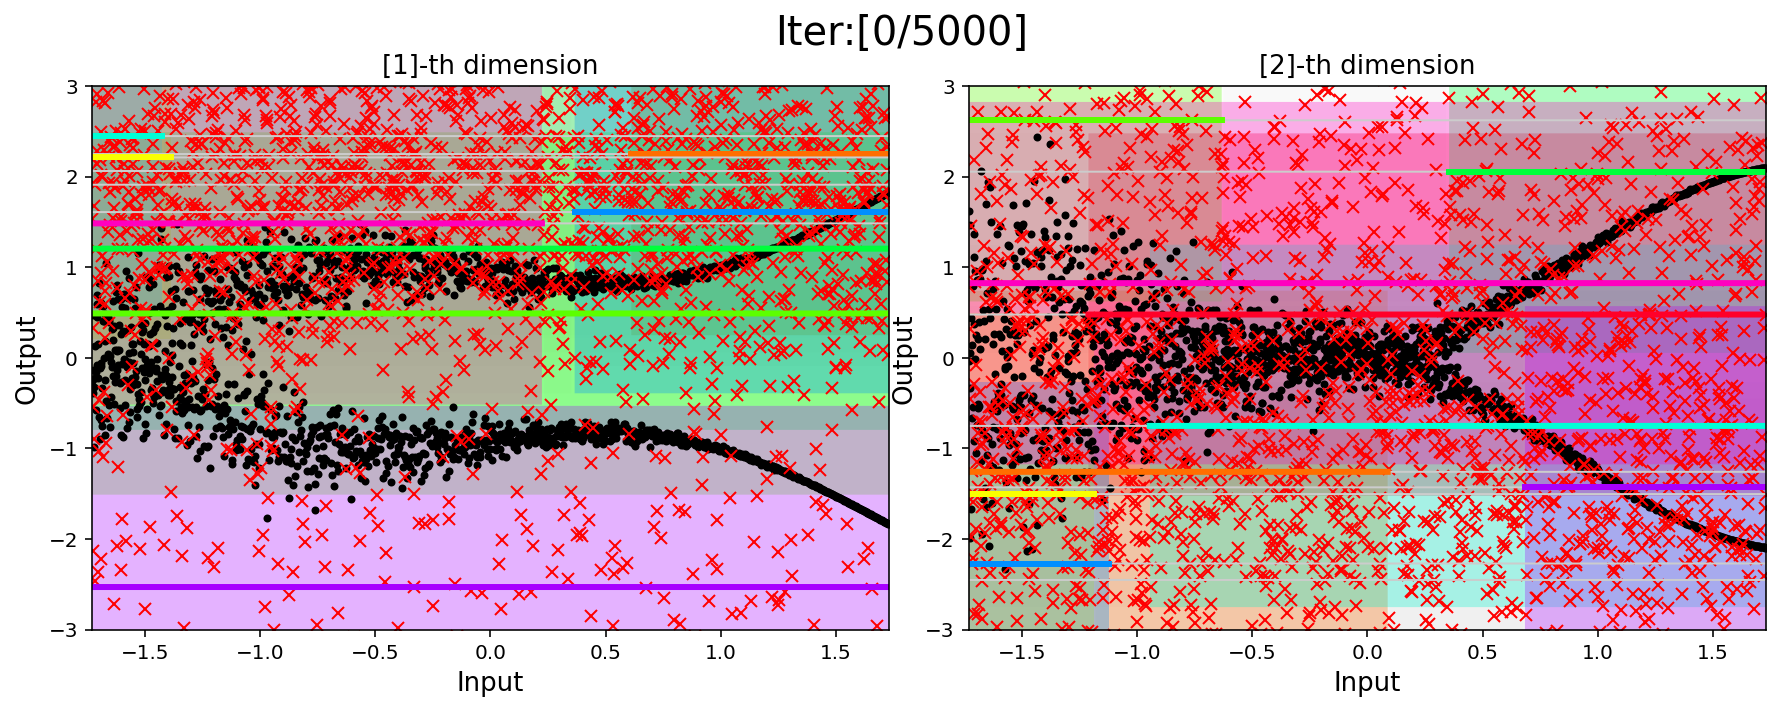

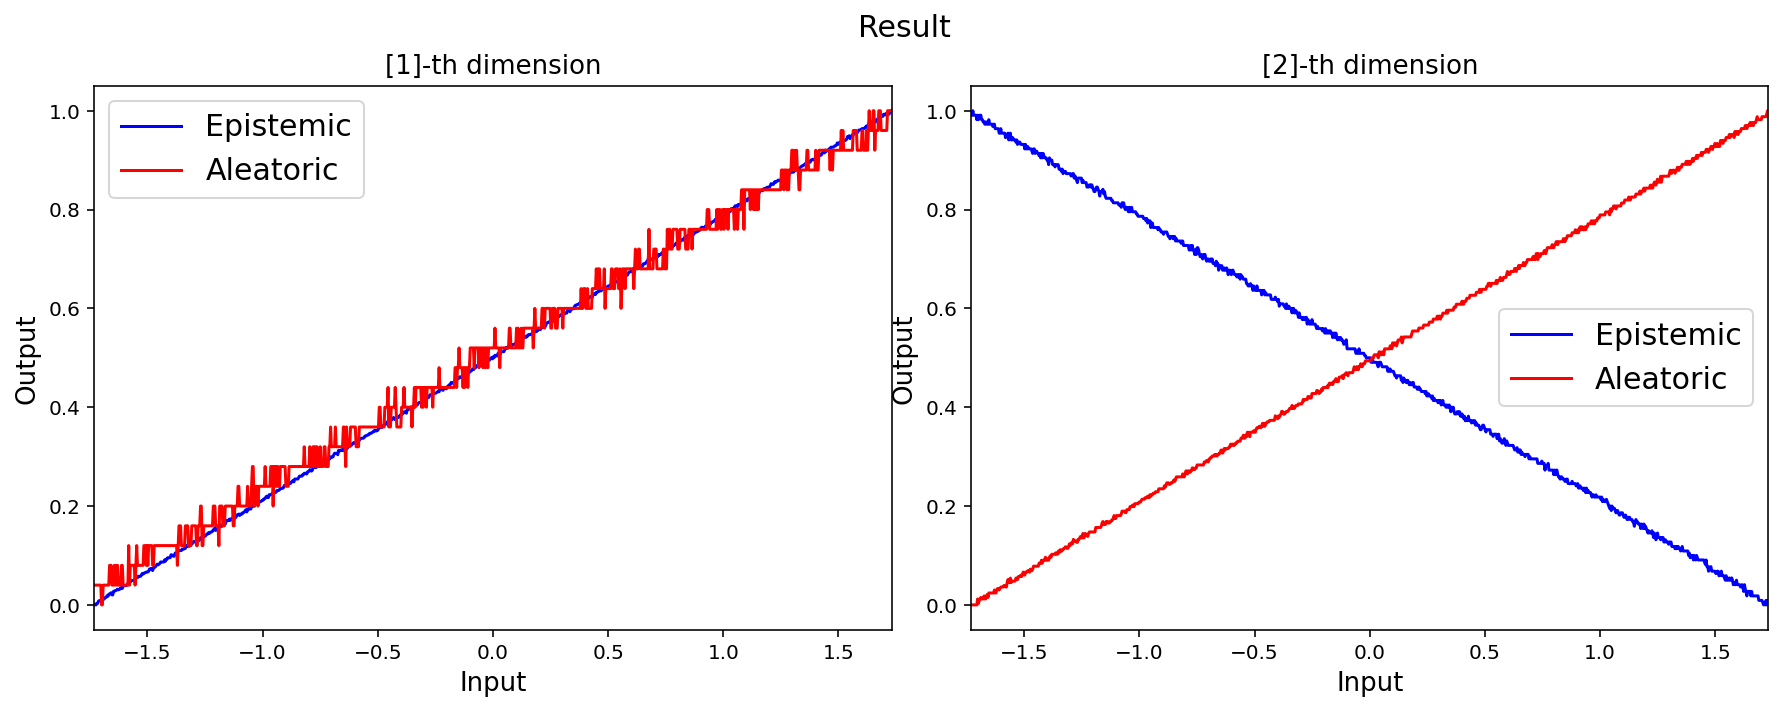

Iter:[100/5000] cost:[1.961]=nll[2.007]+l2reg[0.000]+epireg[-0.046].
Iter:[200/5000] cost:[1.420]=nll[1.434]+l2reg[0.000]+epireg[-0.014].
Iter:[300/5000] cost:[1.113]=nll[1.122]+l2reg[0.000]+epireg[-0.010].
Iter:[400/5000] cost:[1.041]=nll[1.053]+l2reg[0.000]+epireg[-0.012].
Iter:[500/5000] cost:[0.979]=nll[0.992]+l2reg[0.000]+epireg[-0.012].
Iter:[600/5000] cost:[0.654]=nll[0.670]+l2reg[0.000]+epireg[-0.016].
Iter:[700/5000] cost:[0.361]=nll[0.379]+l2reg[0.000]+epireg[-0.018].
Iter:[800/5000] cost:[0.410]=nll[0.426]+l2reg[0.000]+epireg[-0.017].
Iter:[900/5000] cost:[0.228]=nll[0.246]+l2reg[0.000]+epireg[-0.018].
Iter:[1000/5000] cost:[0.017]=nll[0.035]+l2reg[0.000]+epireg[-0.018].


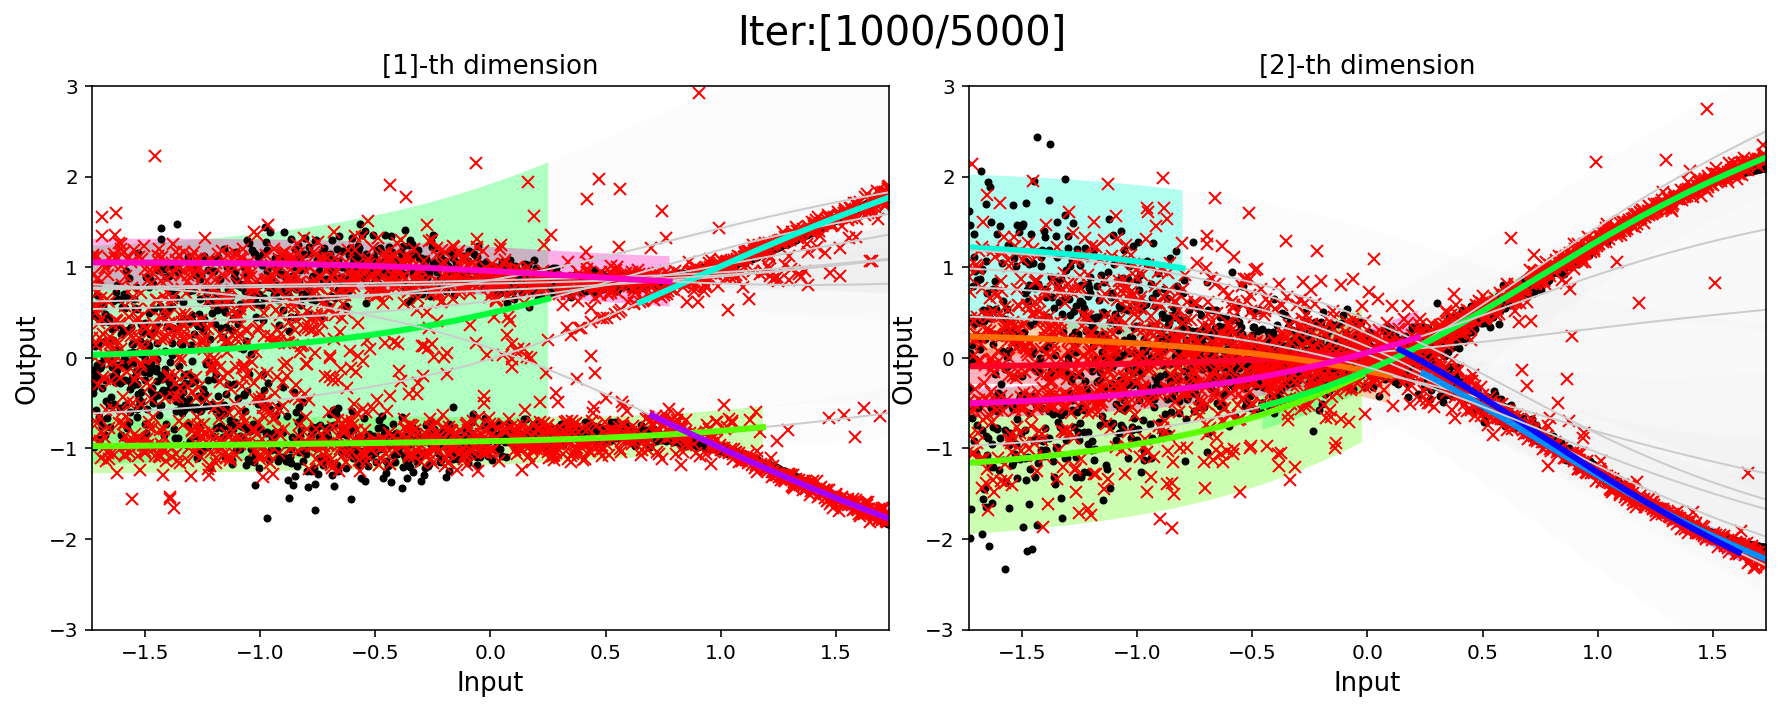

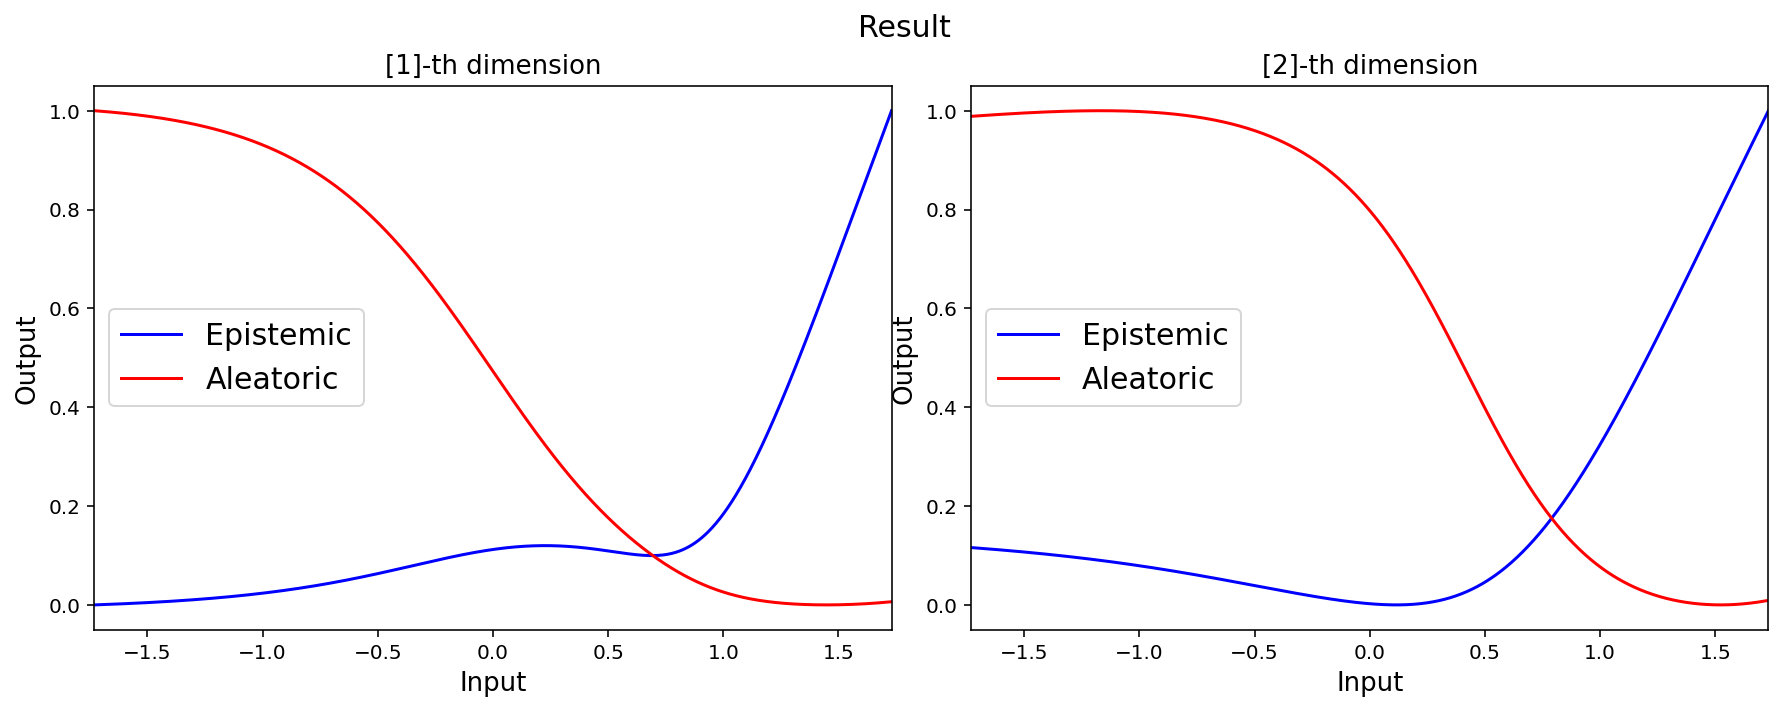

Iter:[1100/5000] cost:[0.410]=nll[0.429]+l2reg[0.000]+epireg[-0.019].
Iter:[1200/5000] cost:[0.028]=nll[0.047]+l2reg[0.000]+epireg[-0.020].
Iter:[1300/5000] cost:[0.042]=nll[0.059]+l2reg[0.000]+epireg[-0.017].
Iter:[1400/5000] cost:[-0.138]=nll[-0.118]+l2reg[0.000]+epireg[-0.020].
Iter:[1500/5000] cost:[-0.022]=nll[-0.005]+l2reg[0.000]+epireg[-0.016].
Iter:[1600/5000] cost:[0.059]=nll[0.077]+l2reg[0.000]+epireg[-0.018].
Iter:[1700/5000] cost:[0.119]=nll[0.136]+l2reg[0.000]+epireg[-0.018].
Iter:[1800/5000] cost:[-0.170]=nll[-0.149]+l2reg[0.000]+epireg[-0.022].
Iter:[1900/5000] cost:[-0.114]=nll[-0.093]+l2reg[0.000]+epireg[-0.021].
Iter:[2000/5000] cost:[-0.057]=nll[-0.040]+l2reg[0.000]+epireg[-0.017].


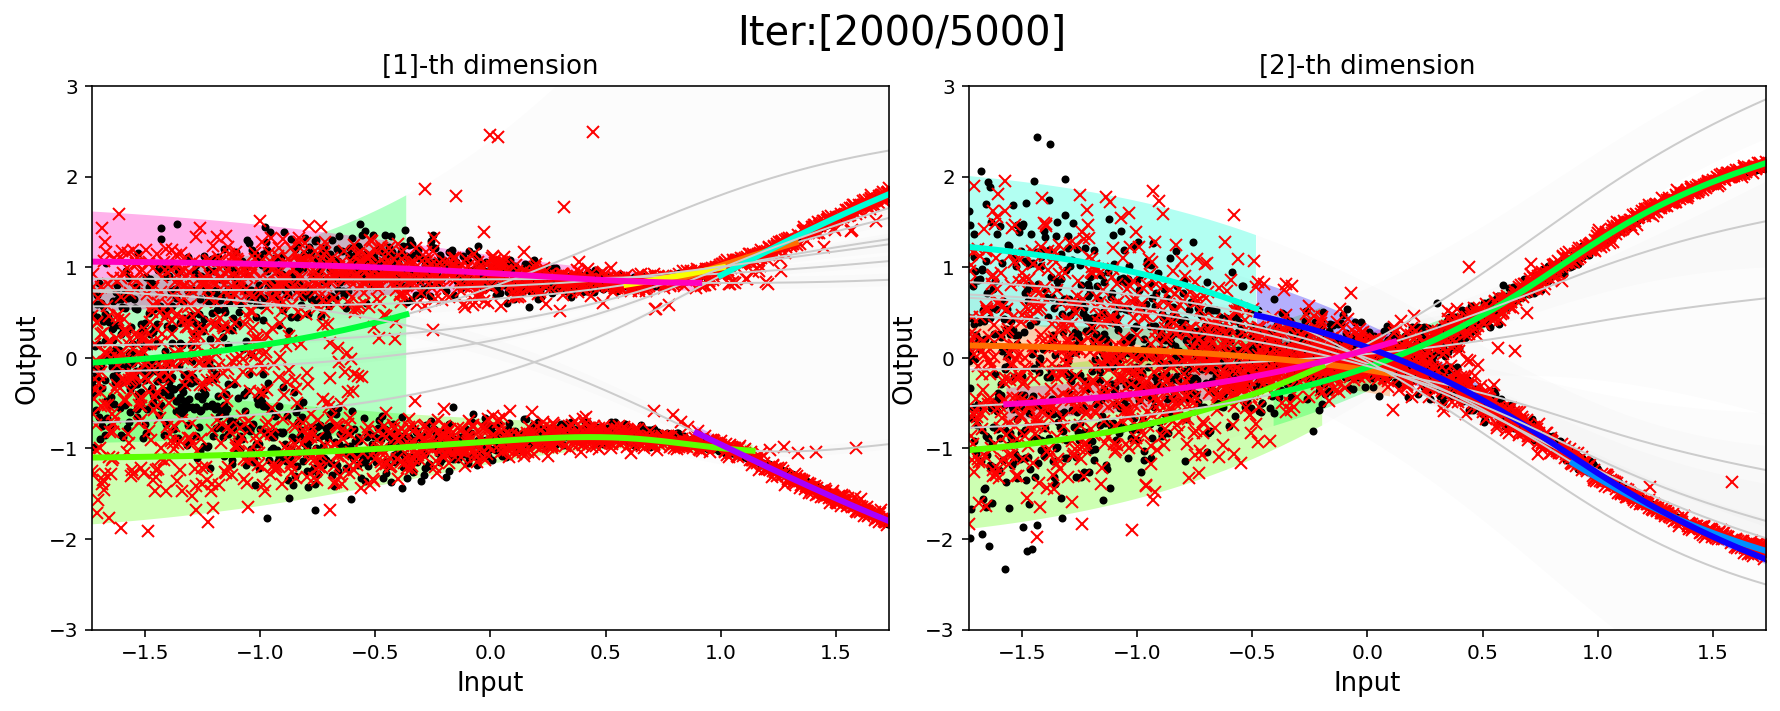

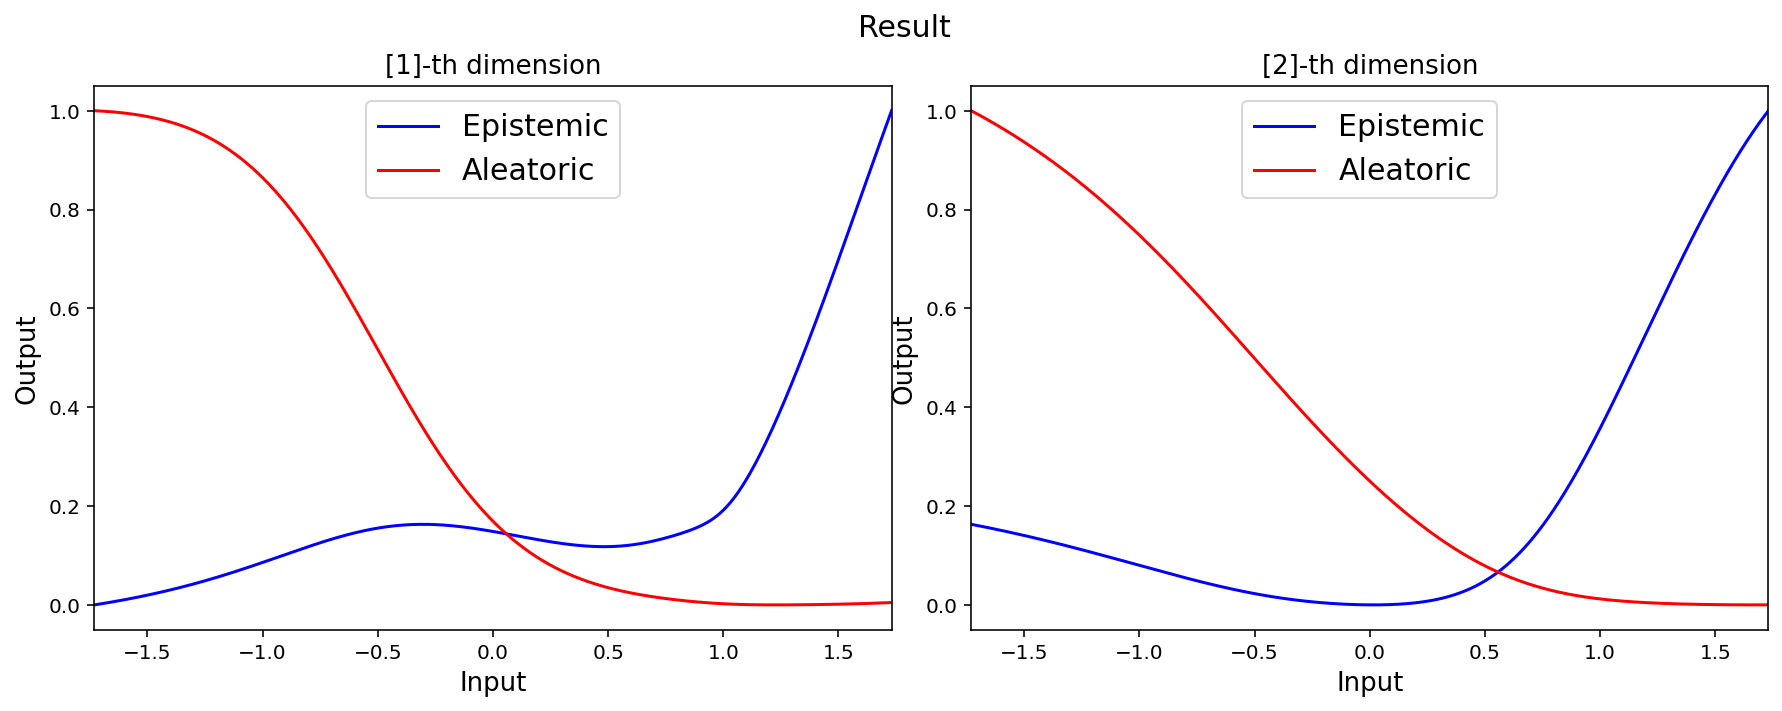

Iter:[2100/5000] cost:[-0.170]=nll[-0.152]+l2reg[0.000]+epireg[-0.018].
Iter:[2200/5000] cost:[-0.132]=nll[-0.114]+l2reg[0.000]+epireg[-0.018].
Iter:[2300/5000] cost:[-0.025]=nll[-0.007]+l2reg[0.000]+epireg[-0.018].
Iter:[2400/5000] cost:[-0.069]=nll[-0.050]+l2reg[0.000]+epireg[-0.019].
Iter:[2500/5000] cost:[-0.022]=nll[-0.007]+l2reg[0.000]+epireg[-0.016].
Iter:[2600/5000] cost:[0.156]=nll[0.176]+l2reg[0.000]+epireg[-0.020].
Iter:[2700/5000] cost:[-0.163]=nll[-0.146]+l2reg[0.000]+epireg[-0.017].
Iter:[2800/5000] cost:[-0.120]=nll[-0.101]+l2reg[0.000]+epireg[-0.019].
Iter:[2900/5000] cost:[-0.202]=nll[-0.182]+l2reg[0.000]+epireg[-0.020].
Iter:[3000/5000] cost:[-0.177]=nll[-0.156]+l2reg[0.000]+epireg[-0.021].


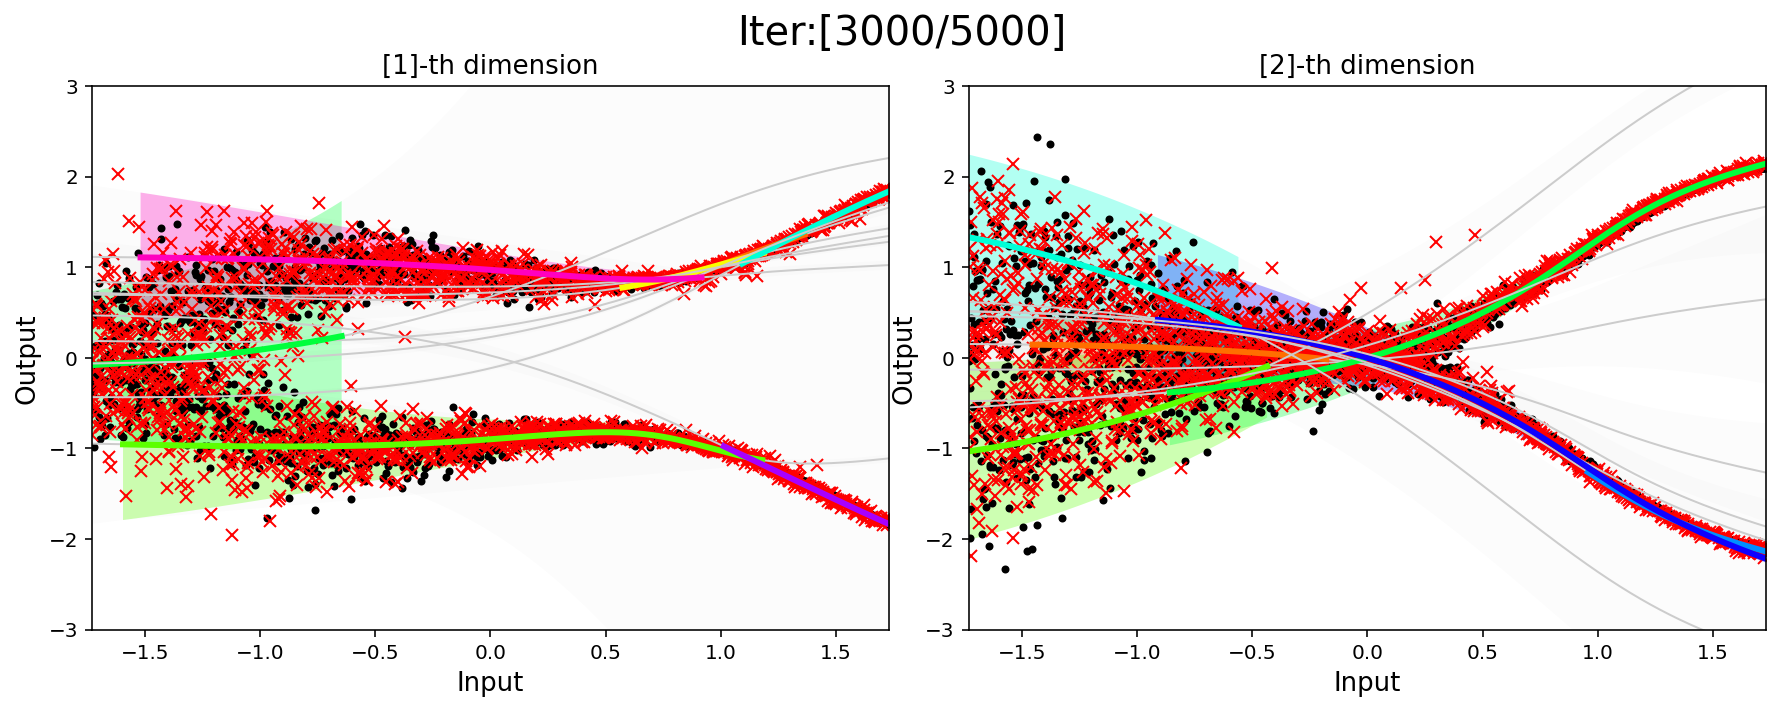

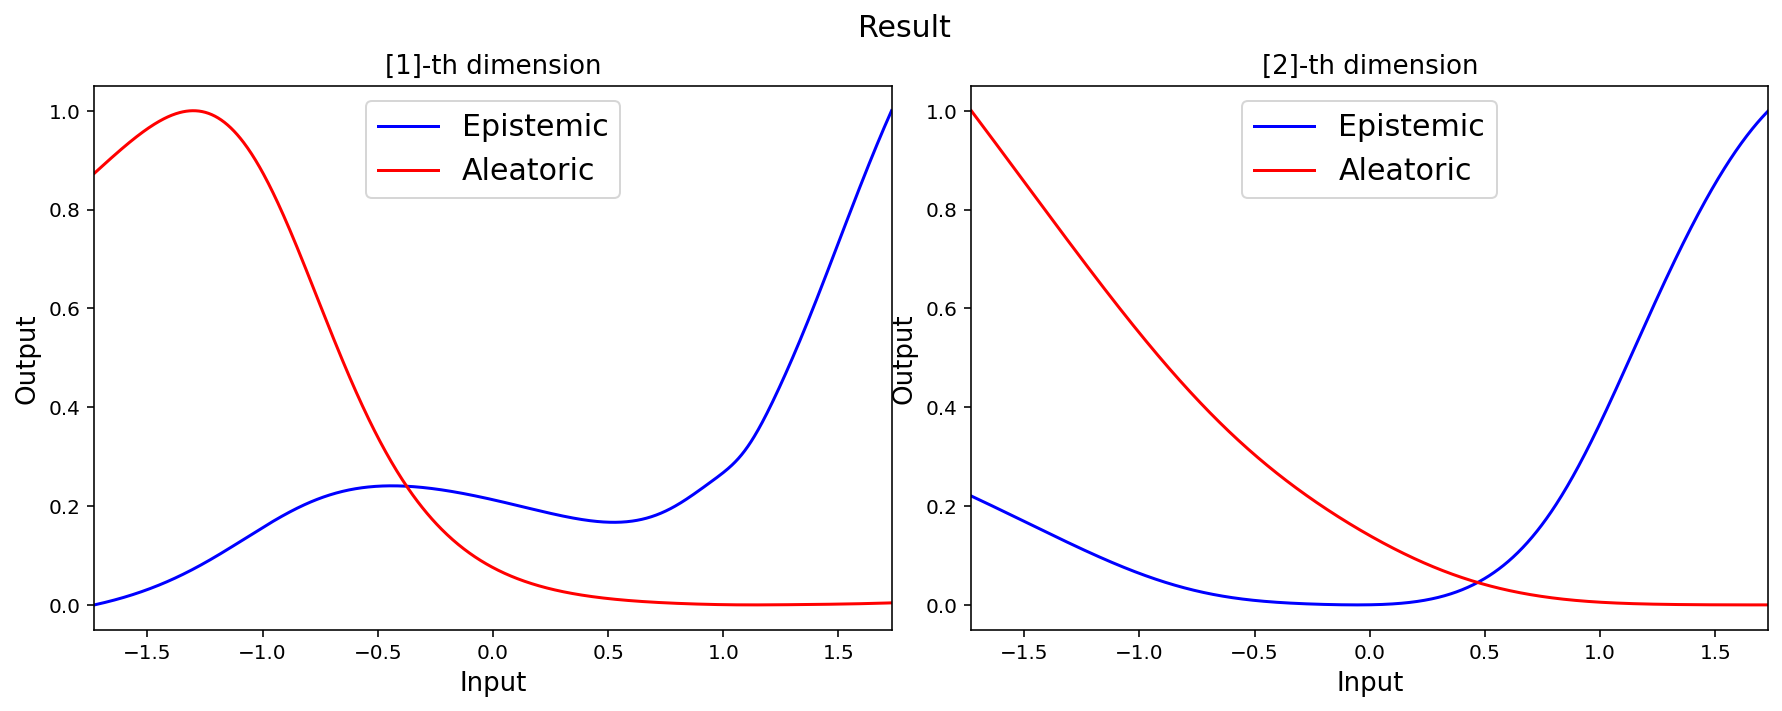

Iter:[3100/5000] cost:[-0.227]=nll[-0.209]+l2reg[0.000]+epireg[-0.018].
Iter:[3200/5000] cost:[-0.397]=nll[-0.376]+l2reg[0.000]+epireg[-0.021].
Iter:[3300/5000] cost:[-0.141]=nll[-0.122]+l2reg[0.000]+epireg[-0.019].
Iter:[3400/5000] cost:[-0.089]=nll[-0.072]+l2reg[0.000]+epireg[-0.017].
Iter:[3500/5000] cost:[-0.239]=nll[-0.224]+l2reg[0.000]+epireg[-0.016].
Iter:[3600/5000] cost:[-0.172]=nll[-0.154]+l2reg[0.000]+epireg[-0.018].
Iter:[3700/5000] cost:[-0.104]=nll[-0.086]+l2reg[0.000]+epireg[-0.018].
Iter:[3800/5000] cost:[-0.276]=nll[-0.259]+l2reg[0.000]+epireg[-0.018].
Iter:[3900/5000] cost:[-0.210]=nll[-0.192]+l2reg[0.000]+epireg[-0.018].
Iter:[4000/5000] cost:[-0.275]=nll[-0.257]+l2reg[0.000]+epireg[-0.019].


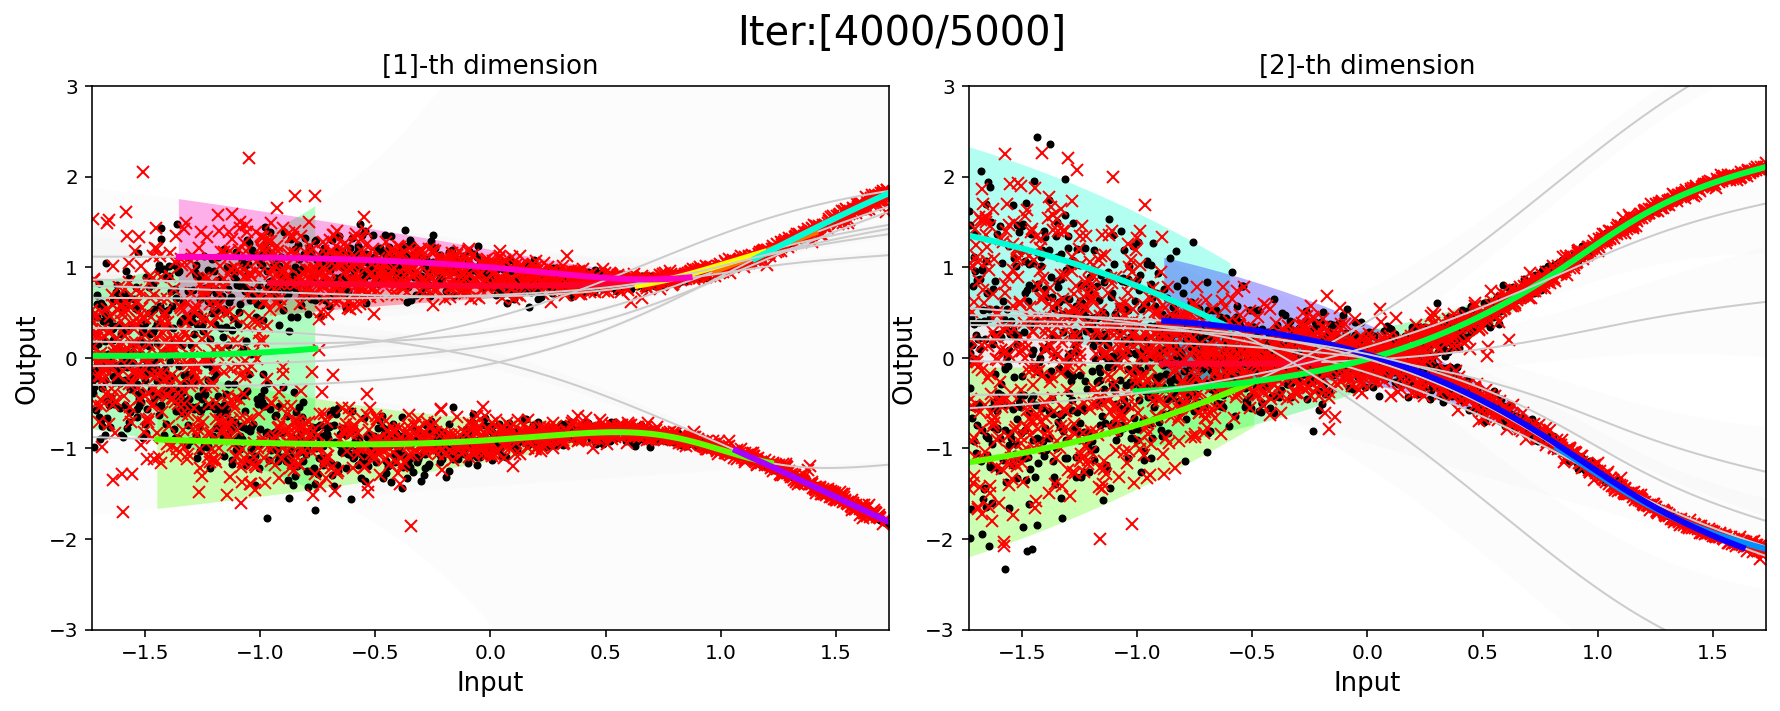

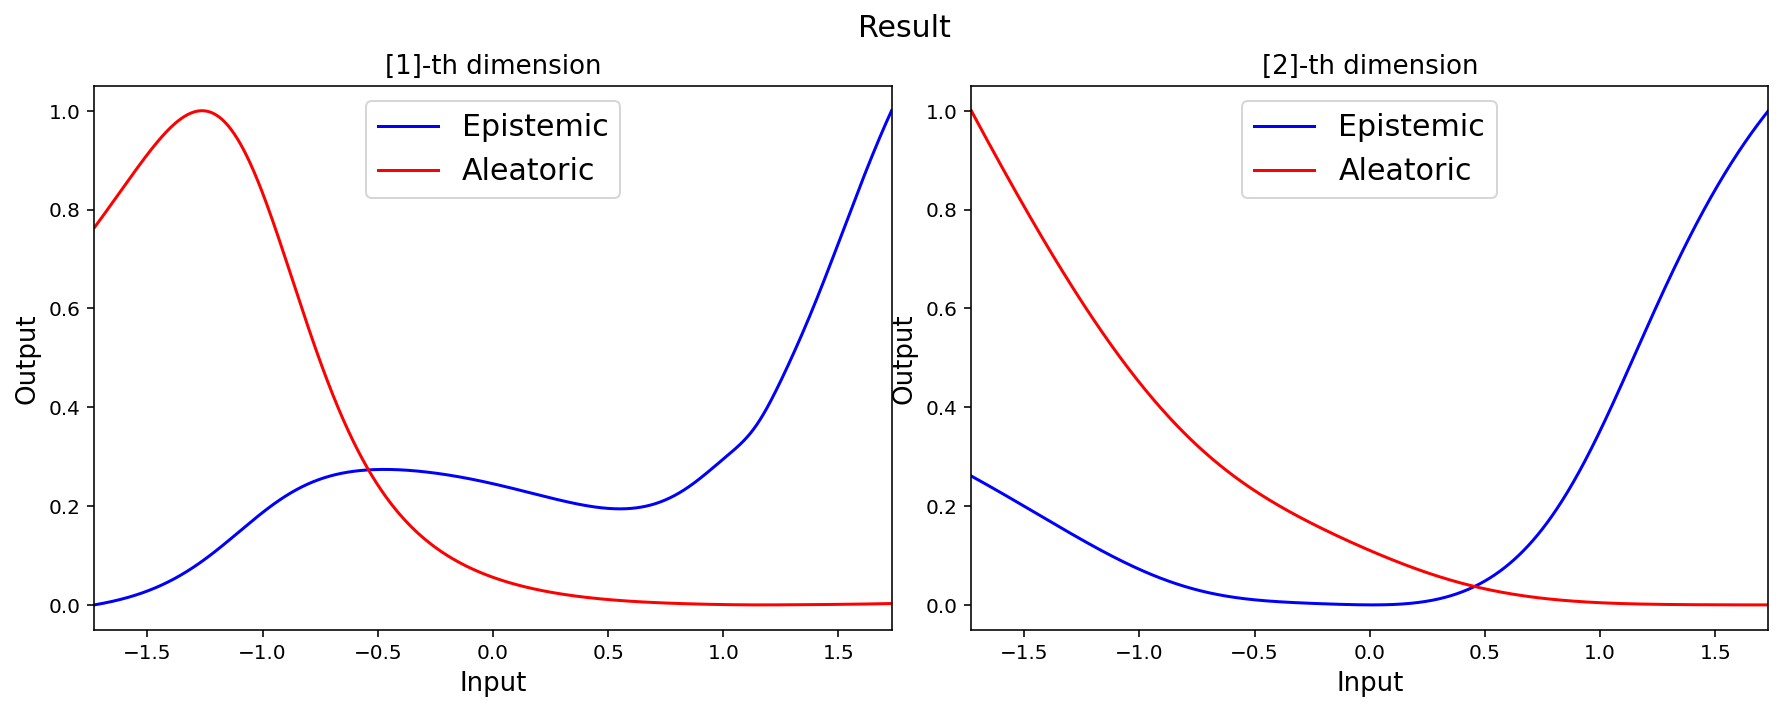

Iter:[4100/5000] cost:[0.050]=nll[0.067]+l2reg[0.000]+epireg[-0.017].
Iter:[4200/5000] cost:[-0.289]=nll[-0.270]+l2reg[0.000]+epireg[-0.020].
Iter:[4300/5000] cost:[-0.126]=nll[-0.109]+l2reg[0.000]+epireg[-0.017].
Iter:[4400/5000] cost:[-0.114]=nll[-0.096]+l2reg[0.000]+epireg[-0.018].
Iter:[4500/5000] cost:[-0.283]=nll[-0.264]+l2reg[0.000]+epireg[-0.019].
Iter:[4600/5000] cost:[-0.263]=nll[-0.245]+l2reg[0.000]+epireg[-0.018].
Iter:[4700/5000] cost:[-0.171]=nll[-0.155]+l2reg[0.000]+epireg[-0.017].
Iter:[4800/5000] cost:[-0.432]=nll[-0.410]+l2reg[0.000]+epireg[-0.022].
Iter:[4900/5000] cost:[-0.302]=nll[-0.282]+l2reg[0.000]+epireg[-0.020].
Done.


In [5]:
max_iter,batch_size,print_every,plot_every = 5000,128,100,1000
for it in range(max_iter):
    r_idx = np.random.permutation(n)[:batch_size]
    x_batch,y_batch = x_train[r_idx,:],y_train[r_idx,:] # current batch
    cost_val,nll_val,l2_reg_val,epi_reg_val = M.update(sess,x_batch,y_batch)
    
    if ((it%print_every)==0) or (iter==(max_iter-1)):
        print ("Iter:[%d/%d] cost:[%.3f]=nll[%.3f]+l2reg[%.3f]+epireg[%.3f]."%
               (it,max_iter,cost_val,nll_val,l2_reg_val,epi_reg_val))
        
    if ((it%plot_every)==0) or (iter==(max_iter-1)):
        M.plot_test_result(
            sess,x_test=x_train,x_train=x_train,y_train=y_train,pi_th=0.1,
            ylim=[-3,+3],title_str='Iter:[%d/%d]'%(it,max_iter),tfs=20
        )
        M.plot_test_uncertainty(sess,x_train)
print ("Done.")

### Instantiate MDN model with Independent Output

In [6]:
tf.reset_default_graph()
sess = gpu_sess()
M = MixtureDensityNetworkClass(
    x_dim=x_dim,y_dim=y_dim,k=10,
    mu_min=-3,mu_max=3,l2_reg_coef=1e-6,epi_reg_coef=1e-2,
    DEPENDENT_OUTPUT=True)
sess.run(tf.global_variables_initializer())
print ("[%s] instantiated."%(M.name))

[MDN] instantiated.


Iter:[0/5000] cost:[3.535]=nll[3.584]+l2reg[0.000]+epireg[-0.049].


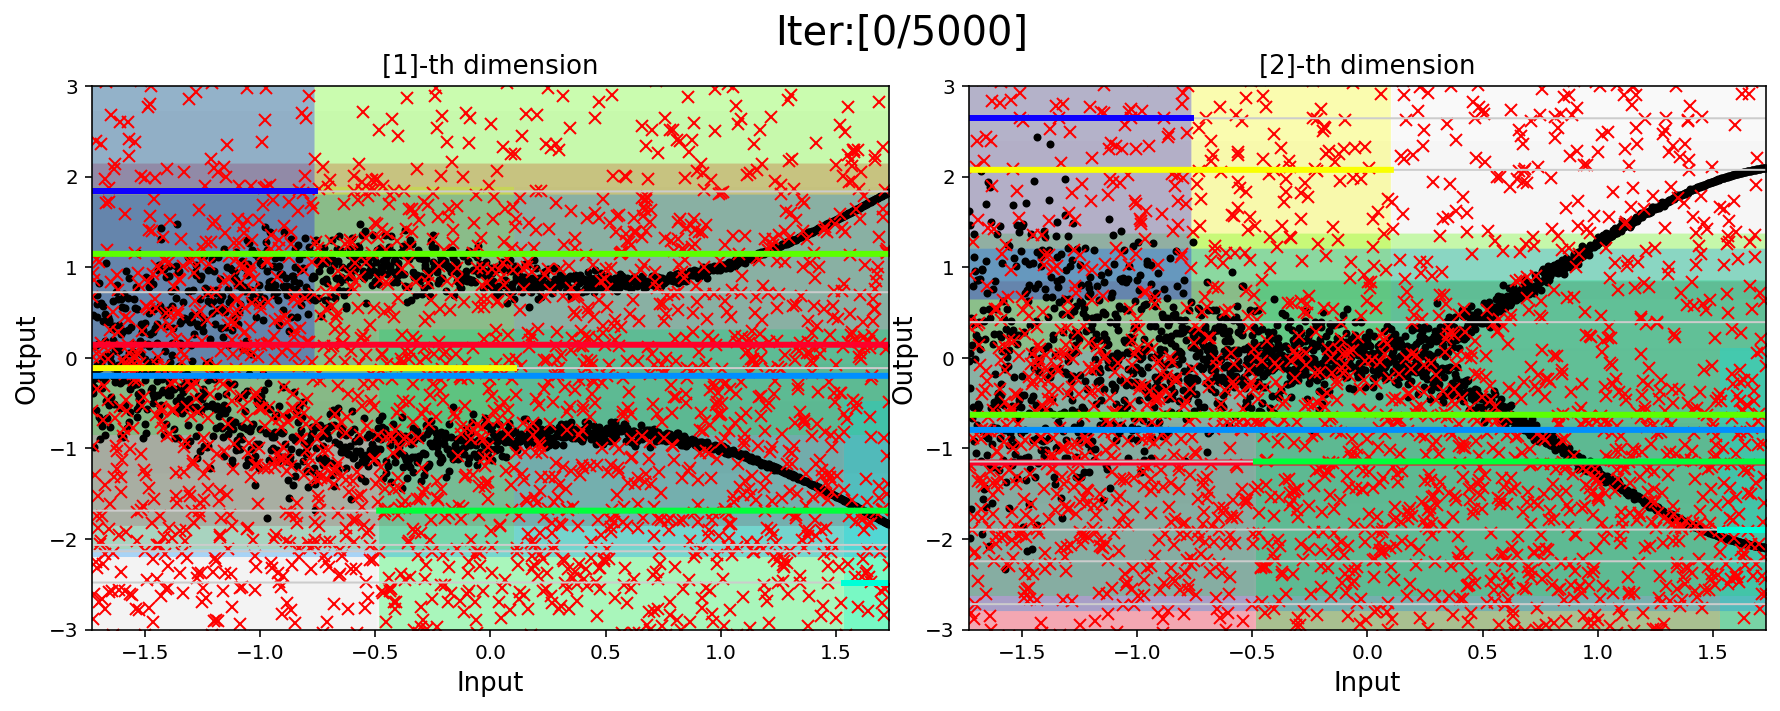

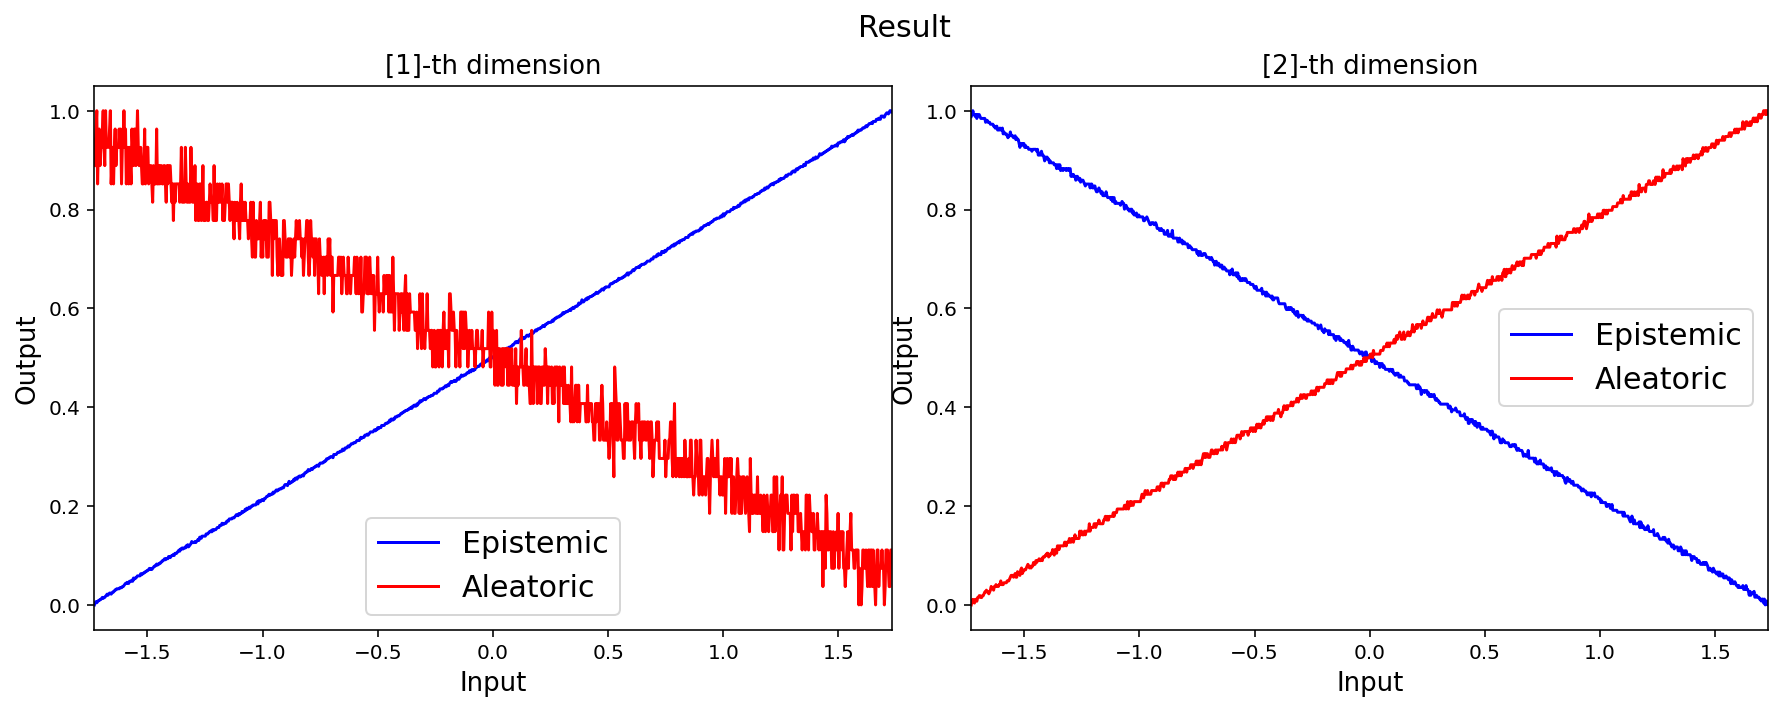

Iter:[100/5000] cost:[3.383]=nll[3.428]+l2reg[0.000]+epireg[-0.045].
Iter:[200/5000] cost:[2.135]=nll[2.145]+l2reg[0.000]+epireg[-0.011].
Iter:[300/5000] cost:[1.731]=nll[1.743]+l2reg[0.000]+epireg[-0.012].
Iter:[400/5000] cost:[1.469]=nll[1.482]+l2reg[0.000]+epireg[-0.013].
Iter:[500/5000] cost:[1.467]=nll[1.480]+l2reg[0.000]+epireg[-0.013].
Iter:[600/5000] cost:[1.436]=nll[1.448]+l2reg[0.000]+epireg[-0.012].
Iter:[700/5000] cost:[1.309]=nll[1.322]+l2reg[0.000]+epireg[-0.013].
Iter:[800/5000] cost:[1.062]=nll[1.075]+l2reg[0.000]+epireg[-0.012].
Iter:[900/5000] cost:[0.542]=nll[0.555]+l2reg[0.000]+epireg[-0.013].
Iter:[1000/5000] cost:[0.687]=nll[0.702]+l2reg[0.000]+epireg[-0.015].


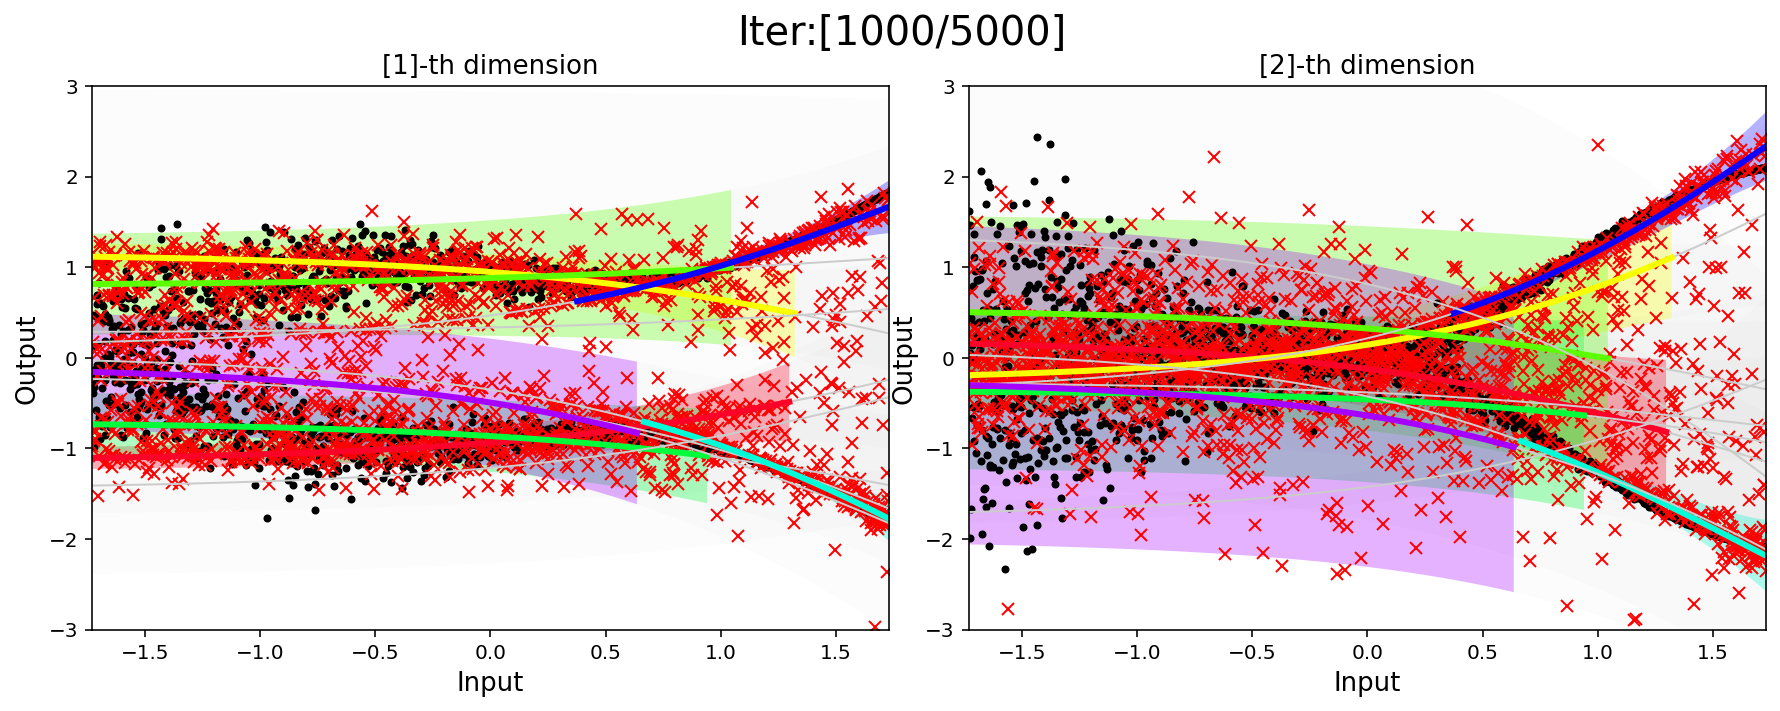

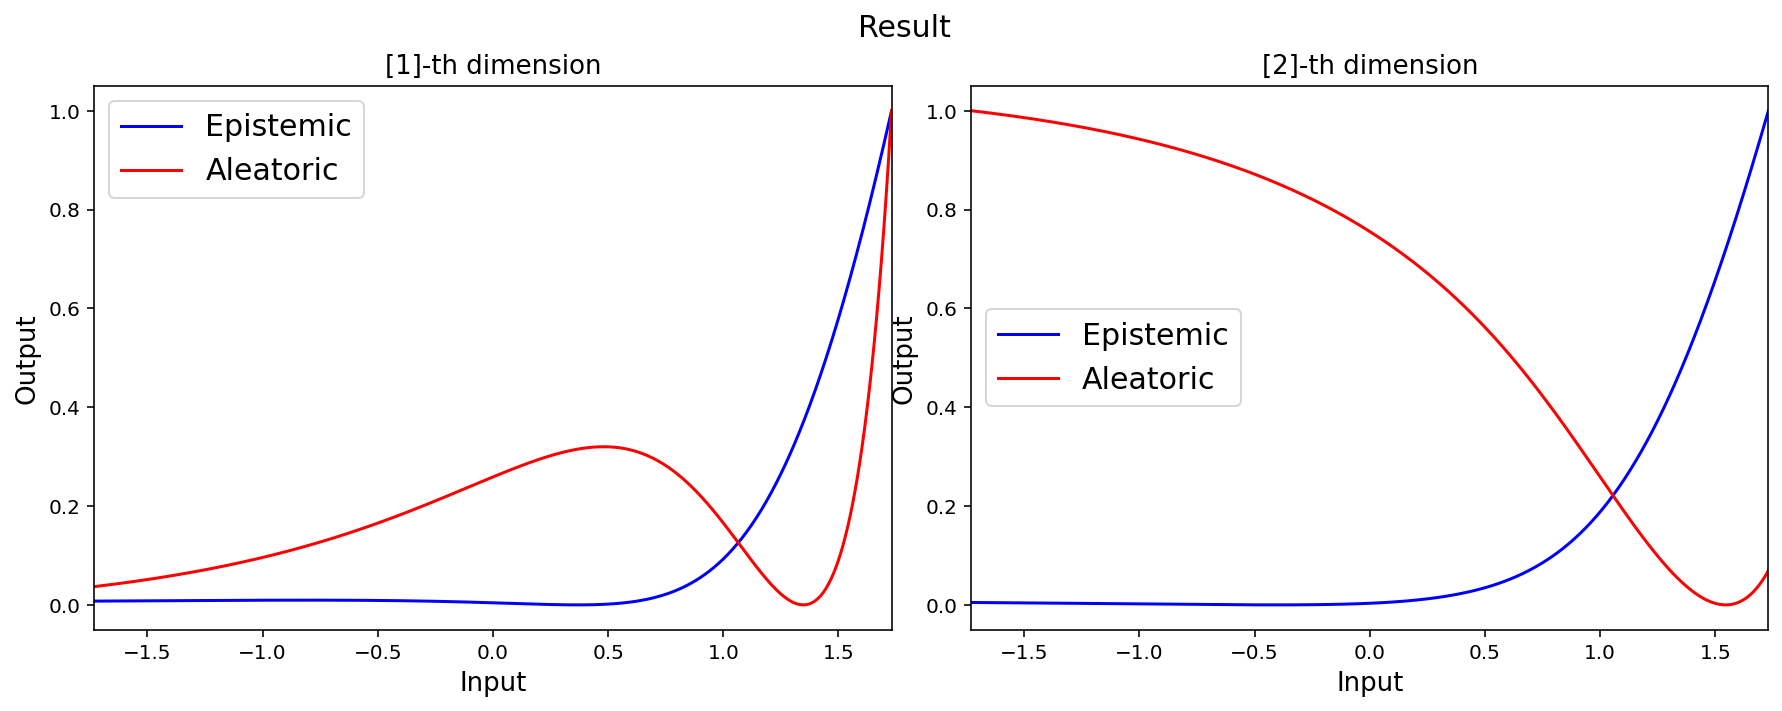

Iter:[1100/5000] cost:[0.322]=nll[0.336]+l2reg[0.000]+epireg[-0.014].
Iter:[1200/5000] cost:[0.688]=nll[0.705]+l2reg[0.000]+epireg[-0.017].
Iter:[1300/5000] cost:[0.218]=nll[0.236]+l2reg[0.000]+epireg[-0.018].
Iter:[1400/5000] cost:[0.079]=nll[0.102]+l2reg[0.000]+epireg[-0.023].
Iter:[1500/5000] cost:[0.568]=nll[0.585]+l2reg[0.000]+epireg[-0.017].
Iter:[1600/5000] cost:[-0.104]=nll[-0.083]+l2reg[0.000]+epireg[-0.021].
Iter:[1700/5000] cost:[0.051]=nll[0.071]+l2reg[0.000]+epireg[-0.019].
Iter:[1800/5000] cost:[-0.190]=nll[-0.172]+l2reg[0.000]+epireg[-0.018].
Iter:[1900/5000] cost:[0.134]=nll[0.151]+l2reg[0.000]+epireg[-0.017].
Iter:[2000/5000] cost:[0.081]=nll[0.099]+l2reg[0.000]+epireg[-0.018].


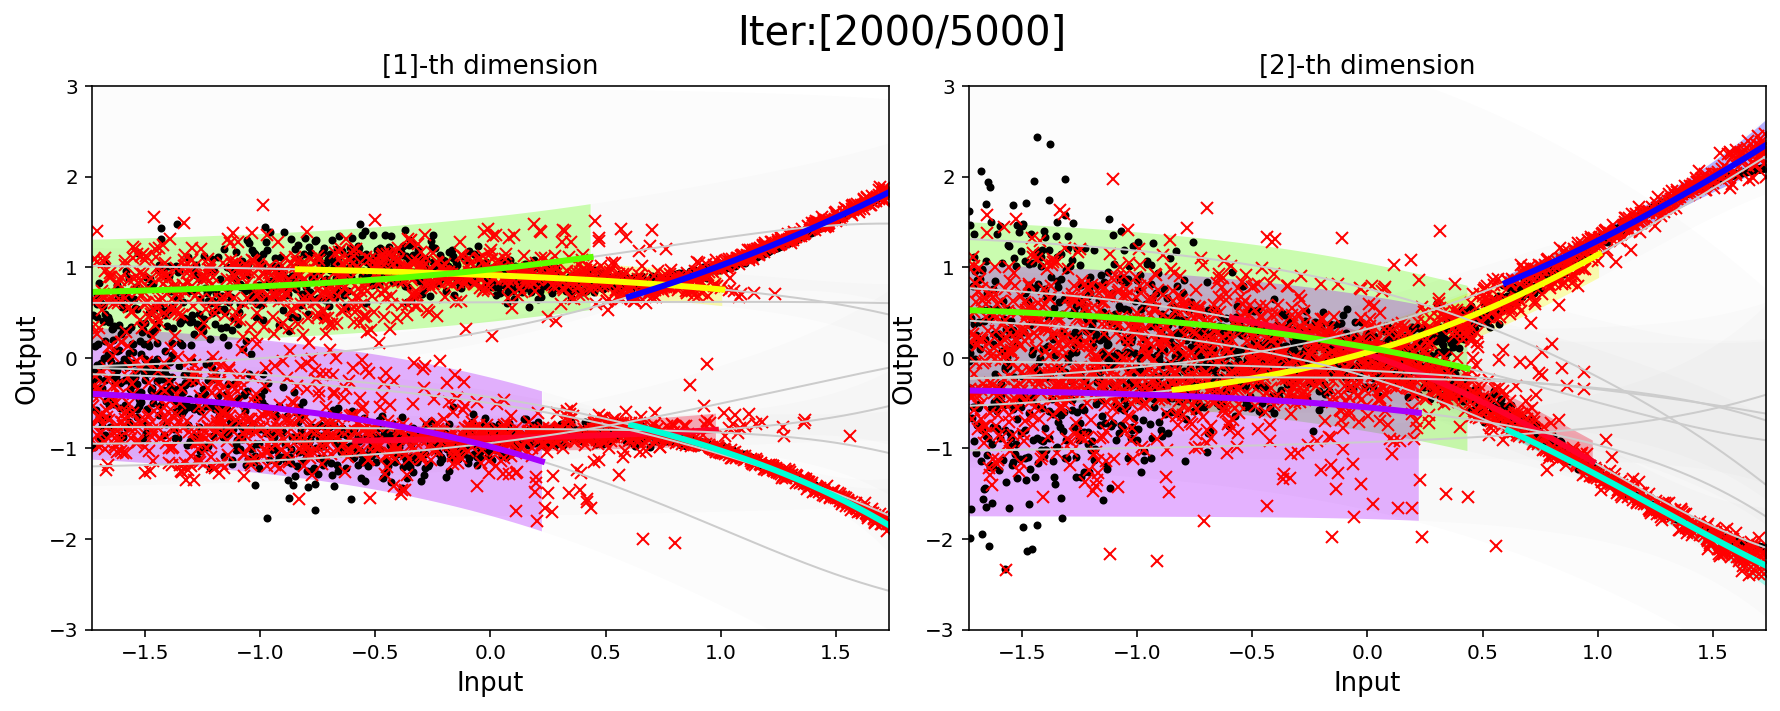

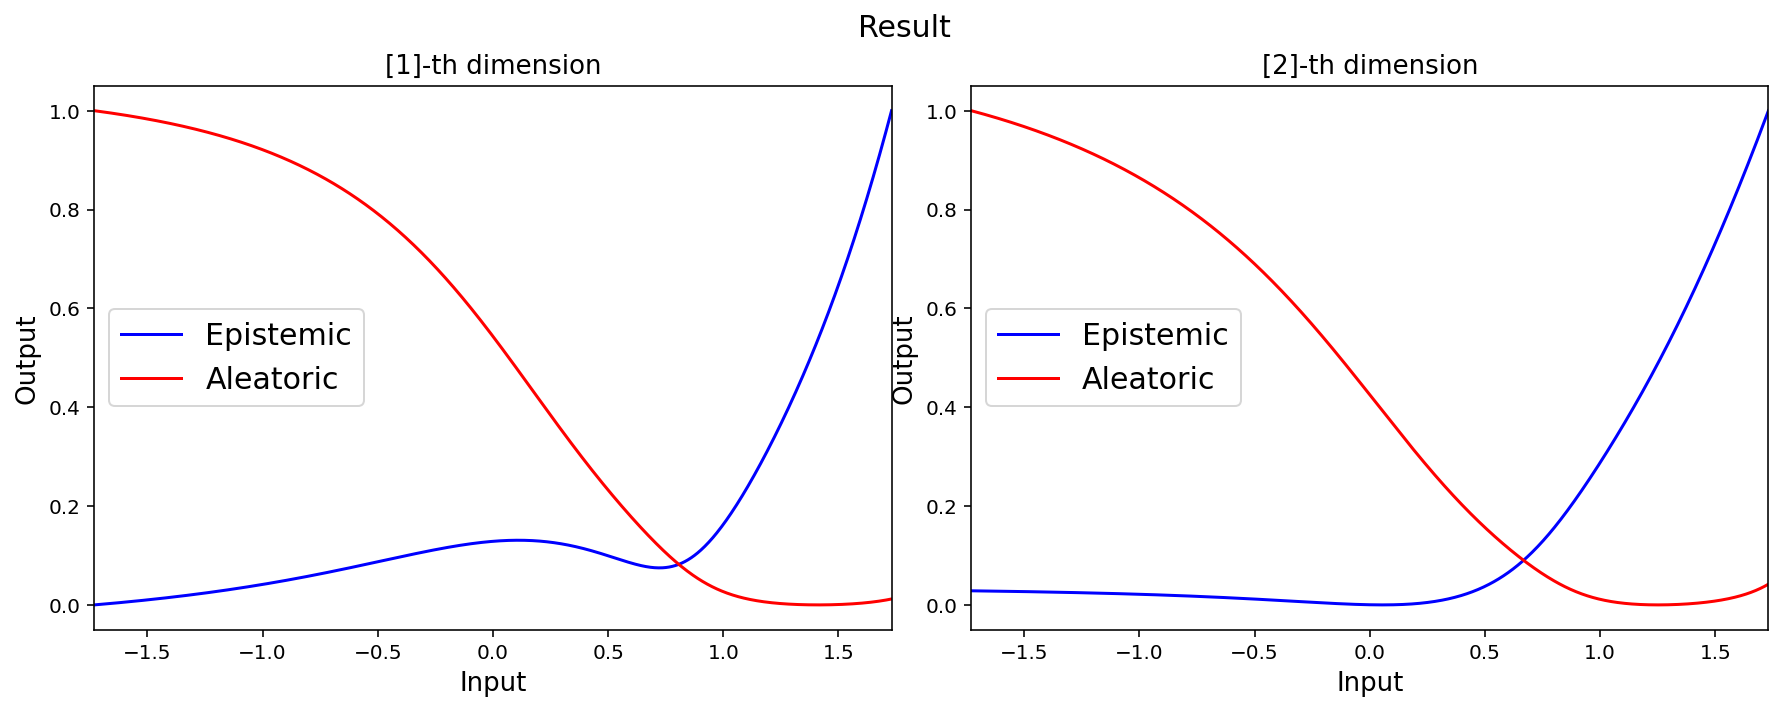

Iter:[2100/5000] cost:[-0.116]=nll[-0.100]+l2reg[0.000]+epireg[-0.016].
Iter:[2200/5000] cost:[-0.268]=nll[-0.250]+l2reg[0.000]+epireg[-0.018].
Iter:[2300/5000] cost:[0.033]=nll[0.050]+l2reg[0.000]+epireg[-0.017].
Iter:[2400/5000] cost:[-0.624]=nll[-0.603]+l2reg[0.000]+epireg[-0.020].
Iter:[2500/5000] cost:[-0.648]=nll[-0.627]+l2reg[0.000]+epireg[-0.021].
Iter:[2600/5000] cost:[-0.260]=nll[-0.244]+l2reg[0.000]+epireg[-0.016].
Iter:[2700/5000] cost:[-0.874]=nll[-0.856]+l2reg[0.000]+epireg[-0.019].
Iter:[2800/5000] cost:[-0.755]=nll[-0.736]+l2reg[0.000]+epireg[-0.019].
Iter:[2900/5000] cost:[-0.425]=nll[-0.408]+l2reg[0.000]+epireg[-0.017].
Iter:[3000/5000] cost:[-0.936]=nll[-0.917]+l2reg[0.000]+epireg[-0.020].


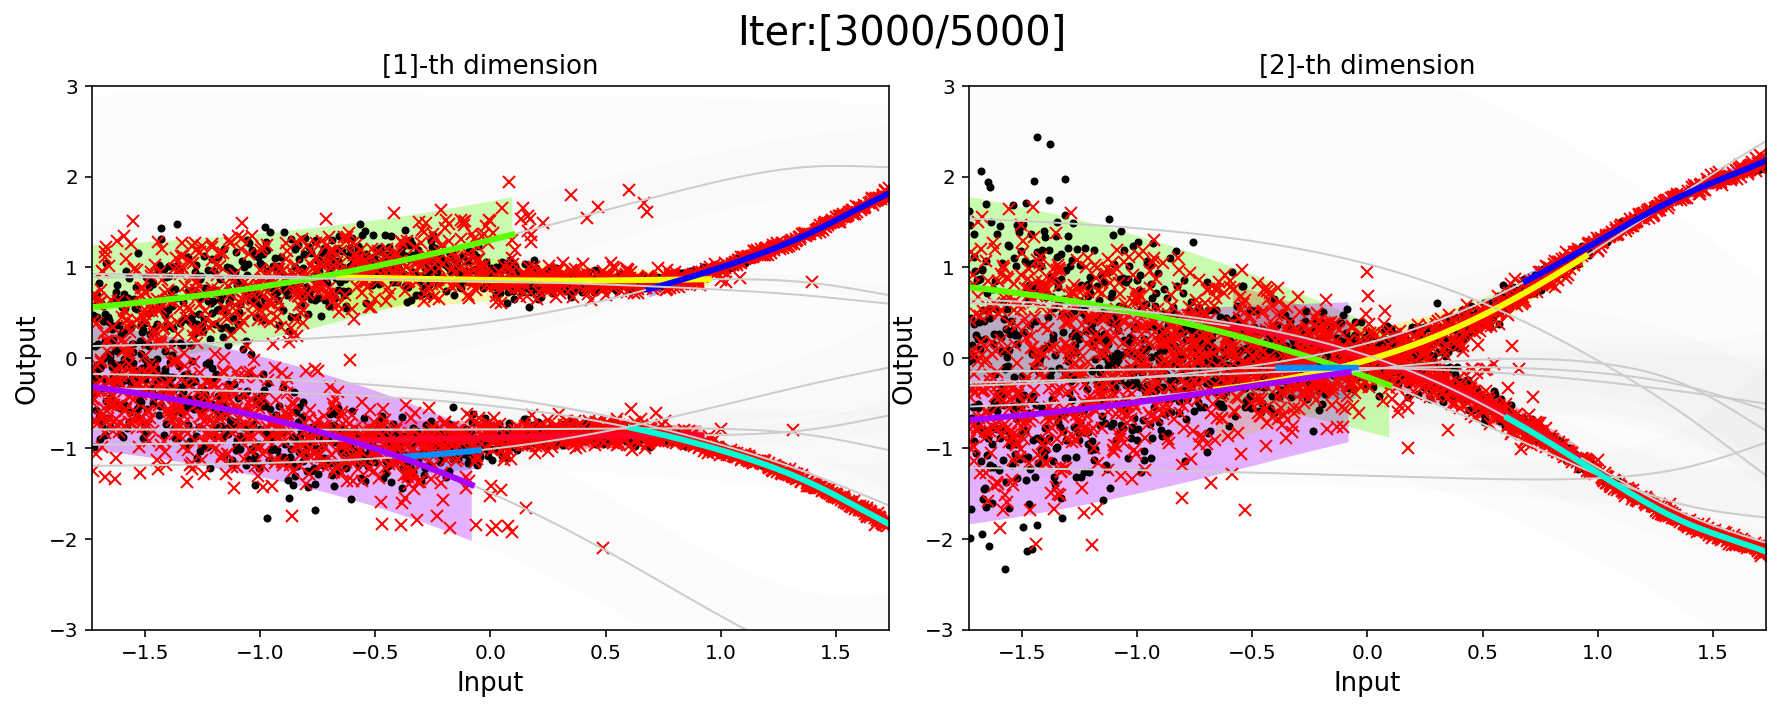

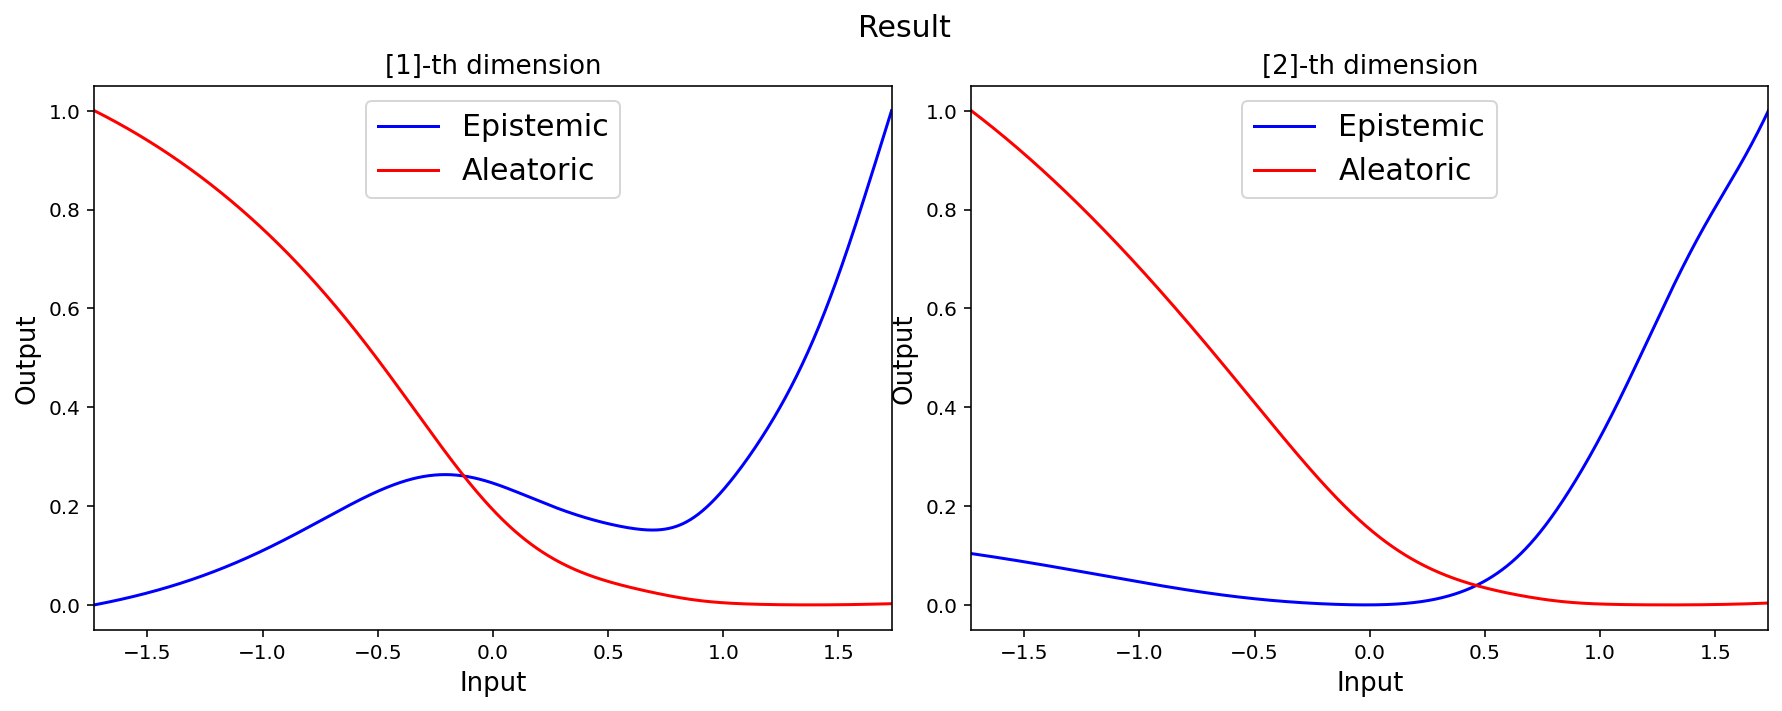

Iter:[3100/5000] cost:[-0.469]=nll[-0.450]+l2reg[0.000]+epireg[-0.019].
Iter:[3200/5000] cost:[-0.727]=nll[-0.706]+l2reg[0.000]+epireg[-0.021].
Iter:[3300/5000] cost:[-1.030]=nll[-1.008]+l2reg[0.000]+epireg[-0.022].
Iter:[3400/5000] cost:[-0.571]=nll[-0.553]+l2reg[0.000]+epireg[-0.018].
Iter:[3500/5000] cost:[-0.606]=nll[-0.588]+l2reg[0.000]+epireg[-0.018].
Iter:[3600/5000] cost:[-0.805]=nll[-0.785]+l2reg[0.000]+epireg[-0.019].
Iter:[3700/5000] cost:[-0.579]=nll[-0.561]+l2reg[0.000]+epireg[-0.017].
Iter:[3800/5000] cost:[-0.763]=nll[-0.741]+l2reg[0.000]+epireg[-0.023].
Iter:[3900/5000] cost:[-0.897]=nll[-0.878]+l2reg[0.000]+epireg[-0.019].
Iter:[4000/5000] cost:[-1.019]=nll[-1.001]+l2reg[0.000]+epireg[-0.018].


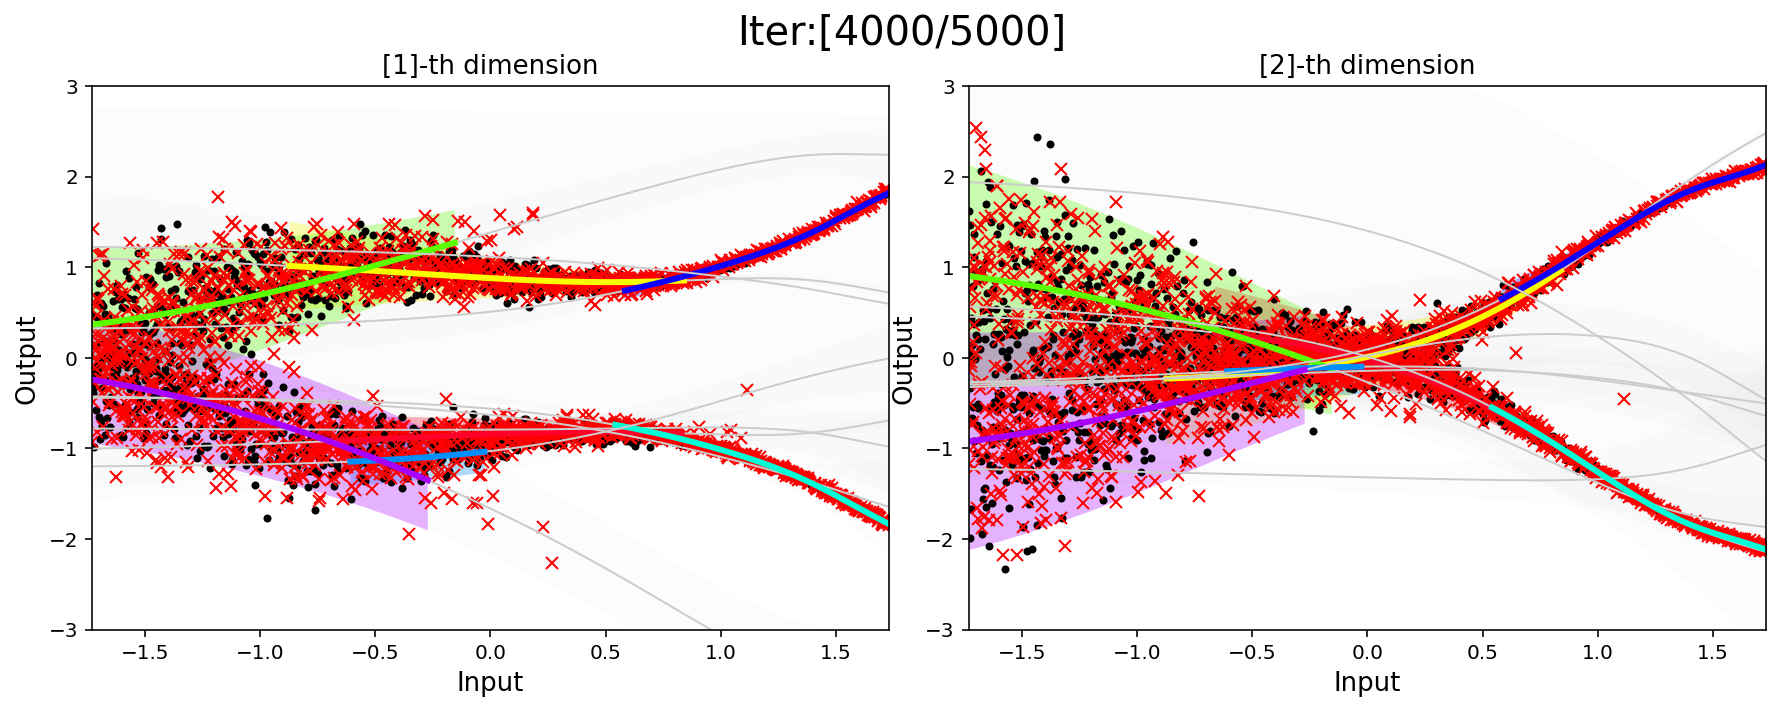

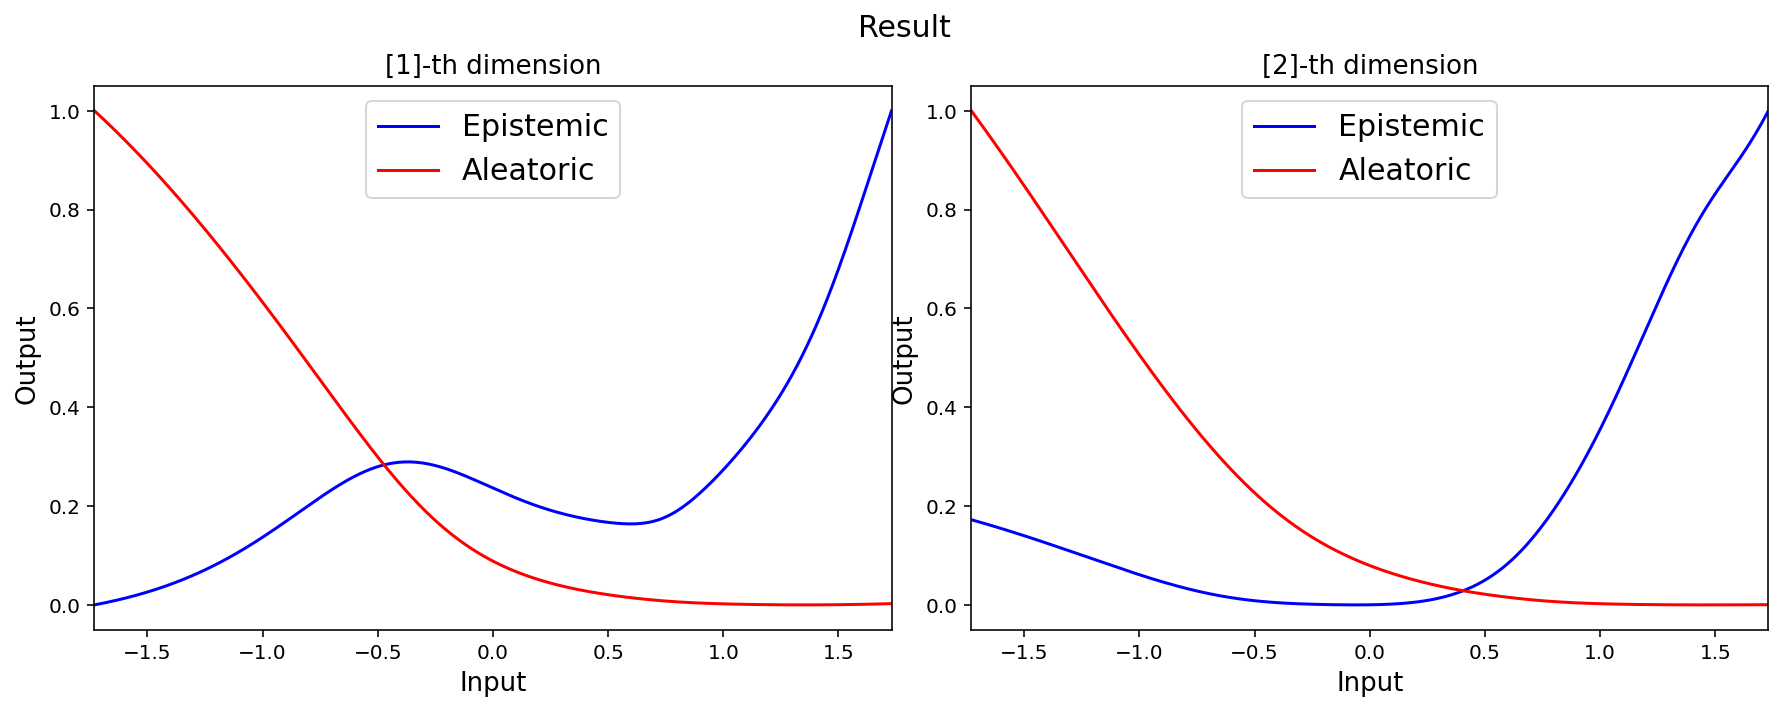

Iter:[4100/5000] cost:[-0.894]=nll[-0.875]+l2reg[0.000]+epireg[-0.020].
Iter:[4200/5000] cost:[-0.978]=nll[-0.960]+l2reg[0.000]+epireg[-0.018].
Iter:[4300/5000] cost:[-0.401]=nll[-0.385]+l2reg[0.000]+epireg[-0.016].
Iter:[4400/5000] cost:[-0.909]=nll[-0.889]+l2reg[0.000]+epireg[-0.020].
Iter:[4500/5000] cost:[-0.628]=nll[-0.611]+l2reg[0.000]+epireg[-0.017].
Iter:[4600/5000] cost:[-0.808]=nll[-0.787]+l2reg[0.000]+epireg[-0.021].
Iter:[4700/5000] cost:[-0.928]=nll[-0.910]+l2reg[0.000]+epireg[-0.018].
Iter:[4800/5000] cost:[-0.140]=nll[-0.121]+l2reg[0.000]+epireg[-0.019].
Iter:[4900/5000] cost:[-0.385]=nll[-0.369]+l2reg[0.000]+epireg[-0.016].
Done.


In [7]:
max_iter,batch_size,print_every,plot_every = 5000,128,100,1000
for it in range(max_iter):
    r_idx = np.random.permutation(n)[:batch_size]
    x_batch,y_batch = x_train[r_idx,:],y_train[r_idx,:] # current batch
    cost_val,nll_val,l2_reg_val,epi_reg_val = M.update(sess,x_batch,y_batch)
    
    if ((it%print_every)==0) or (iter==(max_iter-1)):
        print ("Iter:[%d/%d] cost:[%.3f]=nll[%.3f]+l2reg[%.3f]+epireg[%.3f]."%
               (it,max_iter,cost_val,nll_val,l2_reg_val,epi_reg_val))
        
    if ((it%plot_every)==0) or (iter==(max_iter-1)):
        M.plot_test_result(
            sess,x_test=x_train,x_train=x_train,y_train=y_train,pi_th=0.1,
            ylim=[-3,+3],title_str='Iter:[%d/%d]'%(it,max_iter),tfs=20
        )
        M.plot_test_uncertainty(sess,x_train)
print ("Done.")